# Monte Carlo Method

As a simple example of a Monte Carlo method, we will approximate the value of $\pi$ using a simple Monte-Carlo method:

In [1]:
import numpy as np
import pyopencl as cl
import pyopencl.array
import pyopencl.clrandom
import loopy as lp

In [2]:
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

In [10]:
knl = lp.make_kernel(
        "{ [i, j]: 0<=i<n and 0<=j < 2}",
        """
        <> key2 = make_uint2(i, k1) {inames=i}
        <> ctr = make_uint4(0, 1, 2, 3) {inames=i}
        <> rng_res, ctr = philox4x32_f32(ctr, key2)
        
        samples[i,0] = rng_res.s0 + 1j*rng_res.s1
        samples[i,1] = rng_res.s2 + 1j*rng_res.s3

        accepted[i,j] = real(samples[i,j] * conj(samples[i,j])) < 1
        """)                                                                     

knl = lp.split_iname(knl, "i", 128, outer_tag="g.0", inner_tag="l.0")
knl = lp.set_options(knl, return_dict=True)

In [14]:
knl = lp.set_options(knl, write_cl=False)

In [19]:
evt, result = knl(queue, n=100000, k1=np.int32(99123))

samples = result["samples"].reshape(-1)
accepted = result["accepted"].reshape(-1)

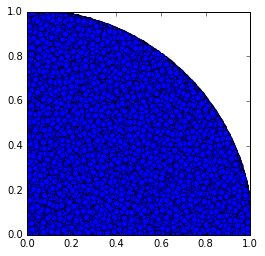

In [22]:
import matplotlib.pyplot as pt

samples_host = samples.get()
accepted_host = accepted.get() != 0

pt.gca().set_aspect("equal")
pt.plot(
    samples_host[accepted_host].real,
    samples_host[accepted_host].imag, "o")

Lastly, we compute the ratio of accepted to the total number of samples to get our approximate value of $\pi$:

In [20]:
4 * cl.array.sum(accepted).get() / len(samples)

3.1429200000000002

We (roughly) expect convergence as $1/\sqrt N$, so this gives an idea of the relative error to expect:

In [8]:
1/np.sqrt(len(samples))

0.0022360679774997899